In [2]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
keras = tf.keras
from datetime import datetime

from typing import List

import os
import glob

from src.io.load import DataLoader

from dataclasses import dataclass, field
from typing import Dict
from src.action_strategy.factory import ActionStrategy
from src.action_strategy.mean_reversion import MeanReversion
from src.forecast.factory import ModelForecastFactory
from src.forecast.runner import ForecastRunner
from src.forecast.utils import SamplerSetForecast
from src.io.load import DataLoader, load_config
from src.io.save import Dumper
from src.preprocessing.preprocess import ProcessData
from src.stock import Balance, Stock
import logging
from src.trade_manager import TradeManagerV0
from datetime import datetime, timedelta
import math
from abc import ABC, abstractmethod

In [4]:
PATH_DATA_PROCESSED = "../data/processed/"

In [5]:
import logging
from src.main import load_config, load_data, Experiment

In [6]:
logging.basicConfig()
log=logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

In [ ]:
!pip install

### Load data

In [48]:
config_file = "1"
# Load config and data
logging.info("Load data and config..")
config_exp = load_config(config_file)
prices = load_data(config_exp["market_name"])
config_exp["date_start"] =  datetime.strptime(' '.join([config_exp["date_start"], config_exp["hour_begin_trade"]]), "%d-%m-%Y %H")
config_exp["date_end"] =  datetime.strptime(' '.join([config_exp["date_end"], config_exp["hour_begin_trade"]]), "%d-%m-%Y %H")

n_days = (config_exp["date_end"] - config_exp["date_start"]).days
config_exp["n_iteration"] = math.ceil(n_days/config_exp["n_frames"])

logging.info("Process data ..")
prices = ProcessData(df=prices).run_preprocess()
prices = prices.to_frame("value")


In [50]:
prices = prices[~prices.value.isna()]

In [10]:
config_exp

{'storage_cpty': 956,
 'storage_pwr': 100,
 'rho_d': 0.86,
 'rho_s': 0.86,
 'eta': 0.7,
 't_discharge': 8,
 'balance_init_level': 1000,
 'init_storage_cpty': 0,
 'market_name': 'germany',
 'date_start': datetime.datetime(2021, 1, 1, 13, 0),
 'date_end': datetime.datetime(2021, 1, 3, 13, 0),
 'hour_begin_trade': '13',
 'alpha': 0.7,
 'period': 23,
 'n_frames': 24,
 'n_iteration': 1}

### Init model

In [369]:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from src.forecast.utils import SamplerSetForecast
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [410]:
#ridge = {"f_forecast","mode":Ridge()}
ridge = Ridge()
lgbm = LGBMRegressor([])

In [409]:
LGBMRegressor()

LGBMRegressor()

In [89]:
data = prices.loc[:pd.datetime(2021, 1, 1)].copy()

/tmp/ipykernel_6681/3241595181.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data = prices.loc[:pd.datetime(2021, 1, 1)].copy()


In [119]:
current = ModelForecastFactory().get_model(**{
                                            "name":"arima",
                                            "order":dict(p=24, d=1, q=0),
                                            "seasonal_order":None,
                                            })

In [ ]:
model_list = []

### Create features

In [90]:
data['week_day'] = data.index.day_of_week+1

In [105]:
data['month'] = data.index.month

/tmp/ipykernel_6681/230665395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data.index.month


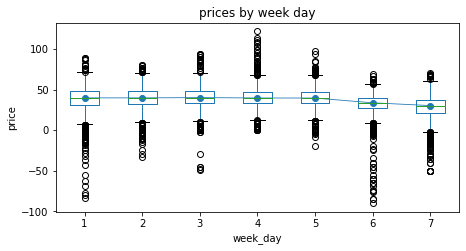

In [72]:
data = prices[:10000].copy()
fig, ax = plt.subplots(figsize=(7, 3.5))
data.boxplot(column='value', by='week_day', ax=ax)
data.groupby('week_day')['value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('price')
ax.set_title('prices by week day')
fig.suptitle('');


In [91]:
lags_features = 24*7
for i in range(1, lags_features+1):
    data['t_{}'.format(i)] = data['value'].shift(i)

/tmp/ipykernel_6681/1647617307.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['t_{}'.format(i)] = data['value'].shift(i)
/tmp/ipykernel_6681/1647617307.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['t_{}'.format(i)] = data['value'].shift(i)
/tmp/ipykernel_6681/1647617307.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

In [92]:
data["weekend"] = np.where(data["week_day"].isin([6, 7]), 1, 0)

/tmp/ipykernel_6681/2041328870.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["weekend"] = np.where(data["week_day"].isin([6, 7]), 1, 0)


In [151]:
data.index.hour

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='time', length=17353)

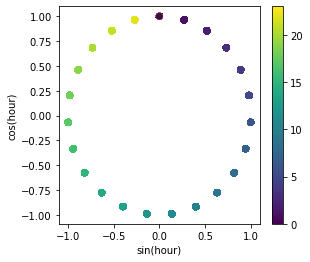

In [165]:
data["hour"] = data.index.hour
data['hour_sin'] = np.sin(data['hour'] / 23 * 2 * np.pi)
data['hour_cos'] = np.cos(data['hour'] / 23 * 2 * np.pi)

# Plot of the transformation
# ==============================================================================
fig, ax = plt.subplots(figsize=(4.5, 4))
sp = ax.scatter(data["hour_sin"], data["hour_cos"], c=data["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

data = data.drop(columns='hour')

In [ ]:
data = data.drop("week_day", axis=1)

In [ ]:
data = data.dropna()

In [411]:
n_frames=48
idx = 15000
x_train = data[:idx].drop("value", axis=1)
y_train = data[:idx]["value"]
x_test = data[idx:(idx+n_frames)].drop("value", axis=1)
y_test = data[idx:(idx+n_frames)]["value"]


In [412]:
lgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type=[])

In [413]:
pred = lgbm.predict(x_test)

In [414]:
mean_squared_error(y_test, pred)

10.803123268273369

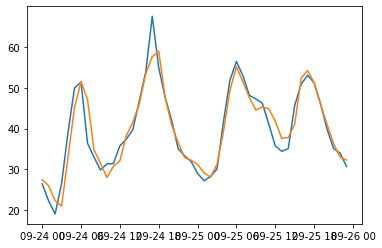

In [415]:
plt.plot(y_test)
plt.plot(y_test.index, pred)

## Sequential predict

On prédit sur la prediction précédente sur n_frames

In [205]:
lags_features = [_ for _ in data.columns if _.startswith('t_')]

In [579]:
n_frames=24
idx = 15000
x_train = data[:idx].drop("value", axis=1)
y_train = data[:idx]["value"]

x_test = data[idx:].drop("value", axis=1)
y_test = data[idx:]["value"]

In [580]:
idx_init = x_test.index[0]
n_days = 30
n_hours_forecast = n_frames*n_days
pred_period = np.zeros((n_days, n_frames))

input_tmp = []
for i, n in enumerate(range(0, n_hours_forecast, n_frames)):
    # every n_frames we init forecaster with known values prices
    x_input = x_test.iloc[n].values
    print(x_train.shape)
    lgbm.fit(x_train, y_train)
    
    pred_day = []
    
    for _ in range(0, n_frames):
        if _ !=0:
            lags_features = [_ for _ in x_test.columns if _.startswith('t_')]
            other_columns = [_ for _ in x_test.columns if _ not in lags_features]
            
            tmp_lags = x_test[lags_features].iloc[n+_].values
            tmp_static = x_test[other_columns].iloc[n+_].values

            # we replace past day prices with forecasted ones
            tmp_lags[:_] = pred_day[::-1][:_]
            
            x_input = np.concatenate((tmp_lags, tmp_static), axis=0)
        
        input_tmp.append(x_input)
        
        last_pred = lgbm.predict(x_input.reshape(1, -1))
        
        pred_day.append(last_pred[0])
    
    pred_period[i,:] = pred_day
        
    x_train = data[:idx+n].drop('value', axis=1)
    y_train = data[:idx+n]['value']

y_test = data[idx:idx+n+_+1]['value']

(15000, 172)
(15000, 172)
(15024, 172)
(15048, 172)
(15072, 172)
(15096, 172)
(15120, 172)
(15144, 172)
(15168, 172)
(15192, 172)
(15216, 172)
(15240, 172)
(15264, 172)
(15288, 172)
(15312, 172)
(15336, 172)
(15360, 172)
(15384, 172)
(15408, 172)
(15432, 172)
(15456, 172)
(15480, 172)
(15504, 172)
(15528, 172)
(15552, 172)
(15576, 172)
(15600, 172)
(15624, 172)
(15648, 172)
(15672, 172)


In [571]:
pred_period.resh

array([[27.15046462, 26.93671664, 27.97283431, 31.18528577, 40.97091433,
        47.63159519, 48.50658477, 43.32579403, 39.05826501, 36.00221056,
        34.75731403, 33.77094474, 33.531165  , 35.72328238, 40.24811676,
        46.55048098, 53.74525344, 60.07022543, 55.91681339, 49.47590212,
        42.76173697, 37.76733774, 35.15299358, 34.07113234],
       [31.19930032, 31.25703686, 32.55265385, 36.65704071, 46.73729352,
        52.09706956, 55.84409332, 51.57922484, 46.49280131, 42.62958674,
        41.07490967, 40.76939747, 41.4612954 , 43.18325976, 47.28156204,
        52.32819555, 57.91241299, 59.59406172, 54.34940144, 48.14296474,
        43.37730709, 39.16930994, 37.00934204, 35.71818378],
       [29.31917594, 28.66130786, 28.72863983, 29.98362556, 33.20846501,
        38.52451892, 41.16017874, 39.3667562 , 35.61015901, 34.53037122,
        33.29398331, 31.2690418 , 29.70636584, 30.12168679, 32.93755601,
        38.34169359, 46.55723639, 51.51434005, 49.48396235, 43.82352382,
  

In [576]:
pred_period.ravel()

array([27.15046462, 26.93671664, 27.97283431, 31.18528577, 40.97091433,
       47.63159519, 48.50658477, 43.32579403, 39.05826501, 36.00221056,
       34.75731403, 33.77094474, 33.531165  , 35.72328238, 40.24811676,
       46.55048098, 53.74525344, 60.07022543, 55.91681339, 49.47590212,
       42.76173697, 37.76733774, 35.15299358, 34.07113234, 31.19930032,
       31.25703686, 32.55265385, 36.65704071, 46.73729352, 52.09706956,
       55.84409332, 51.57922484, 46.49280131, 42.62958674, 41.07490967,
       40.76939747, 41.4612954 , 43.18325976, 47.28156204, 52.32819555,
       57.91241299, 59.59406172, 54.34940144, 48.14296474, 43.37730709,
       39.16930994, 37.00934204, 35.71818378, 29.31917594, 28.66130786,
       28.72863983, 29.98362556, 33.20846501, 38.52451892, 41.16017874,
       39.3667562 , 35.61015901, 34.53037122, 33.29398331, 31.2690418 ,
       29.70636584, 30.12168679, 32.93755601, 38.34169359, 46.55723639,
       51.51434005, 49.48396235, 43.82352382, 39.2425756 , 35.46

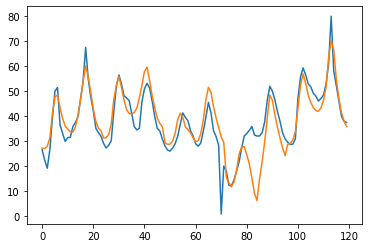

In [578]:
plt.plot(np.arange(n_hours_forecast),y_test[:n_day_forecast])
plt.plot(np.arange(n_hours_forecast), pred_period.ravel()[:n_day_forecast])

In [436]:
x_test[:48]

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_163,t_164,t_165,t_166,t_167,t_168,weekend,month,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,,,,
2020-09-24 00:00:00,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,42.18,...,53.64,48.00,36.56,34.58,34.32,34.73,0,9,0.000000e+00,1.000000
2020-09-24 01:00:00,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,...,59.69,53.64,48.00,36.56,34.58,34.32,0,9,2.697968e-01,0.962917
2020-09-24 02:00:00,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,...,53.91,59.69,53.64,48.00,36.56,34.58,0,9,5.195840e-01,0.854419
2020-09-24 03:00:00,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,...,45.80,53.91,59.69,53.64,48.00,36.56,0,9,7.308360e-01,0.682553
2020-09-24 04:00:00,26.55,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,...,42.00,45.80,53.91,59.69,53.64,48.00,0,9,8.878852e-01,0.460065
2020-09-24 05:00:00,39.18,26.55,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,...,39.89,42.00,45.80,53.91,59.69,53.64,0,9,9.790841e-01,0.203456
2020-09-24 06:00:00,49.97,39.18,26.55,19.08,22.26,26.47,28.44,29.95,32.45,39.02,...,39.07,39.89,42.00,45.80,53.91,59.69,0,9,9.976688e-01,-0.068242
2020-09-24 07:00:00,51.46,49.97,39.18,26.55,19.08,22.26,26.47,28.44,29.95,32.45,...,37.10,39.07,39.89,42.00,45.80,53.91,0,9,9.422609e-01,-0.334880
2020-09-24 08:00:00,36.45,51.46,49.97,39.18,26.55,19.08,22.26,26.47,28.44,29.95,...,36.66,37.10,39.07,39.89,42.00,45.80,0,9,8.169699e-01,-0.576680


In [434]:
y_test

time
2020-09-24 00:00:00    26.47
2020-09-24 01:00:00    22.26
2020-09-24 02:00:00    19.08
2020-09-24 03:00:00    26.55
2020-09-24 04:00:00    39.18
2020-09-24 05:00:00    49.97
2020-09-24 06:00:00    51.46
2020-09-24 07:00:00    36.45
2020-09-24 08:00:00    33.01
2020-09-24 09:00:00    29.84
2020-09-24 10:00:00    31.35
2020-09-24 11:00:00    31.42
2020-09-24 12:00:00    35.79
2020-09-24 13:00:00    37.43
2020-09-24 14:00:00    39.76
2020-09-24 15:00:00    46.84
2020-09-24 16:00:00    53.93
2020-09-24 17:00:00    67.57
2020-09-24 18:00:00    54.94
2020-09-24 19:00:00    47.63
2020-09-24 20:00:00    42.01
2020-09-24 21:00:00    35.09
2020-09-24 22:00:00    33.34
2020-09-24 23:00:00    31.92
2020-09-25 00:00:00    29.03
2020-09-25 01:00:00    27.20
2020-09-25 02:00:00    28.26
2020-09-25 03:00:00    30.10
2020-09-25 04:00:00    41.74
2020-09-25 05:00:00    51.93
2020-09-25 06:00:00    56.48
2020-09-25 07:00:00    52.95
2020-09-25 08:00:00    48.17
2020-09-25 09:00:00    47.27
2020-09-2

In [338]:
len(pred_lgbm)

720

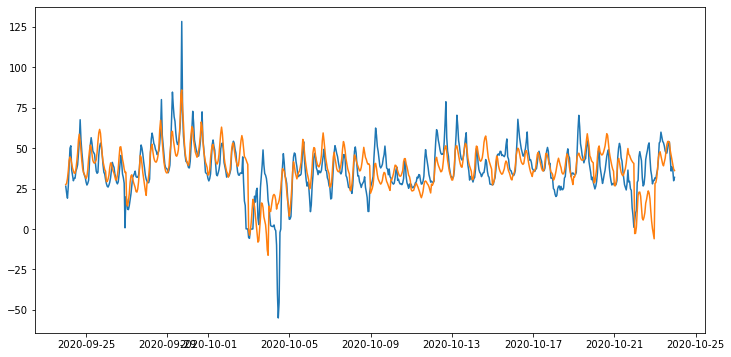

In [366]:
plt.figure(figsize=(12, 6))
stop=5000
plt.plot(y_test[:stop])
plt.plot(y_test.index[:stop], pred_lgbm[:stop])

In [367]:
np.sqrt(mean_squared_error(y_test[:stop], pred_lgbm[:stop]))

11.96692301353229

In [370]:
mean_absolute_error(y_test[:stop], pred_lgbm[:stop])

8.613841278114487

https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html

https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

### Ridge

In [331]:
n_frames=24
idx = 15000
x_train = data[:idx].drop("value", axis=1)
y_train = data[:idx]["value"]

x_test = data[idx:].drop("value", axis=1)
y_test = data[idx:]["value"]

In [332]:
x_test.shape

(2353, 172)

In [333]:
pred_ridge = []
idx_init = x_test.index[0]
n_day_forecast = n_frames*30
for n in range(0, n_day_forecast, n_frames):
    last_pred = x_test.iloc[n]
    ridge.fit(x_train, y_train)
    for _ in range(0, n_frames):
        if _ !=0:
            lags_features = [_ for _ in x_test.columns if _.startswith('t_')]
            other_columns = [_ for _ in x_test.columns if _ not in lags_features]
            
            tmp = x_test[lags_features].iloc[n+_]
            tmp = tmp.shift(1)
            tmp.iloc[0] = last_pred
            last_pred = pd.concat([tmp, x_test.iloc[n+_][other_columns]], axis=0)
            
        last_pred = ridge.predict(last_pred.values.reshape(1, -1))
        pred_ridge.extend(last_pred)
    x_train = data[:idx+n].drop('value', axis=1)
    y_train = data[:idx+n]['value']

y_test = data[idx:idx+n+_+1]['value']

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/martin/miniconda3/envs/rhizom

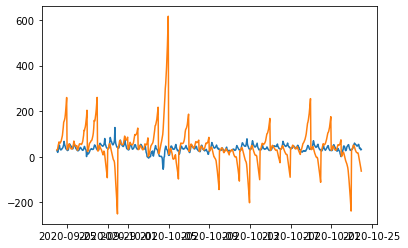

In [334]:
plt.plot(y_test)
plt.plot(y_test.index, pred_ridge)

In [335]:
np.sqrt(mean_squared_error(y_test, pred_ridge))

80.34470494034673

#### Current

In [133]:
current.train_model(y_train)

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [344]:
n_frames=24
idx = 15000
x_train = data[:idx].drop("value", axis=1)
y_train = data[:idx]["value"]

x_test = data[idx:].drop("value", axis=1)
y_test = data[idx:]["value"]

In [363]:
%%time
pred_current = []
n_frames = 24
n_day_forecast = n_frames*30

for n in range(n_frames, n_day_forecast+1, n_frames):
    current.train_model(y_train)
    pred_current.extend(current.forecast(n_frames=n_frames))
    y_train = data[:idx+n]['value']
y_test = data[idx:idx+n]['value']

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_mo

CPU times: user 50min 50s, sys: 2h 49min 27s, total: 3h 40min 17s
Wall time: 13min 58s


In [353]:
for n in range(n_frames, n_day_forecast+1, n_frames):
    print(n)

24
48


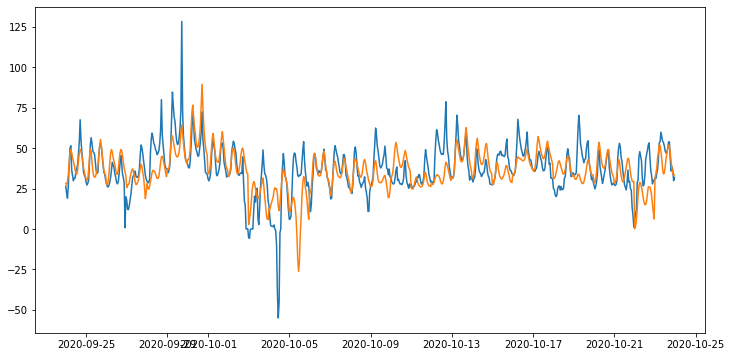

In [364]:
plt.figure(figsize=(12, 6))
plt.plot(y_test)
plt.plot(y_test.index, pred_current)

In [368]:
np.sqrt(mean_squared_error(y_test, pred_current))

12.868678684474256

In [371]:
mean_absolute_error(y_test, pred_current)

9.26026766411571

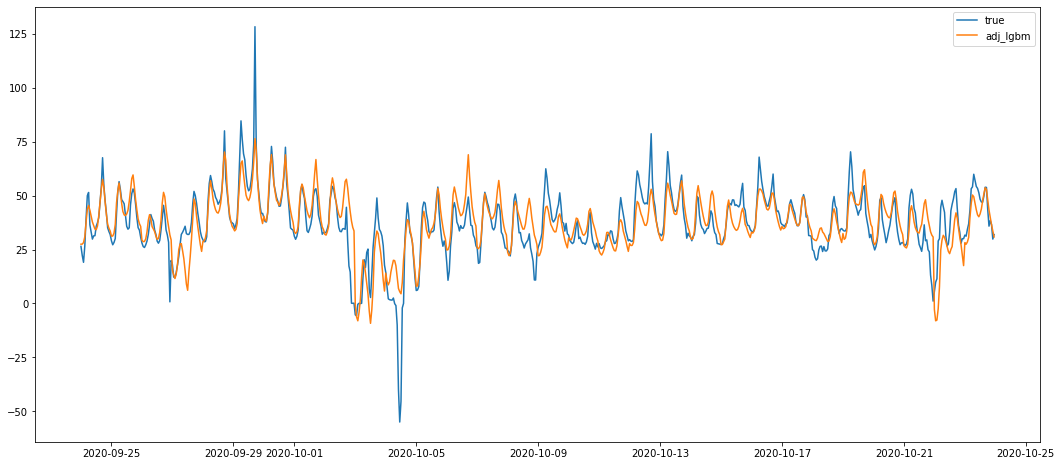

In [584]:
plt.figure(figsize=(18, 8))
plt.plot(y_test, label="true")
#plt.plot(y_test.index, pred_current, label="current_forecast")
#plt.plot(y_test.index, pred_lgbm, label="lgbm_forecast")
plt.plot(y_test.index, pred_period.ravel(), label="adj_lgbm")
plt.scatter(np.arange())
plt.legend()

In [608]:
y_test.index

DatetimeIndex(['2020-09-24 00:00:00', '2020-09-24 01:00:00',
               '2020-09-24 02:00:00', '2020-09-24 03:00:00',
               '2020-09-24 04:00:00', '2020-09-24 05:00:00',
               '2020-09-24 06:00:00', '2020-09-24 07:00:00',
               '2020-09-24 08:00:00', '2020-09-24 09:00:00',
               ...
               '2020-10-23 14:00:00', '2020-10-23 15:00:00',
               '2020-10-23 16:00:00', '2020-10-23 17:00:00',
               '2020-10-23 18:00:00', '2020-10-23 19:00:00',
               '2020-10-23 20:00:00', '2020-10-23 21:00:00',
               '2020-10-23 22:00:00', '2020-10-23 23:00:00'],
              dtype='datetime64[ns]', name='time', length=720, freq=None)

In [375]:
print(mean_absolute_error(y_test, pred_current))
print(mean_absolute_error(y_test, pred_lgbm))

9.26026766411571
8.613841278114487


In [395]:
f"{100-(8.6138/9.260)*100:.2f} % better perf"

'6.98 % better perf'

In [392]:
f"{14*60/15} x better timing"

'56.0 x better timing'

In [51]:
# sampler for train and test sets
sampler = SamplerSetForecast(df=prices, 
                            n_frames=config_exp["n_frames"],
                            )
sampler.init_train_test_set(
    date_start=config_exp["date_start"],
    date_end=config_exp["date_end"],
    )

17533


In [52]:
timedelta(hours=24)

datetime.timedelta(days=1)

In [53]:
sampler.x_train[sampler.x_train.isna()]

Series([], Name: value, dtype: float64)

In [199]:
%%time
n_frames=24
init_idx = 15000
idx = init_idx

pred_ridge = []
pred_lgbm = []
for i in range(1, 10):
    x_train = data[:idx].drop("value", axis=1)
    y_train = data[:idx]["value"]
    x_test = data[idx:(idx+n_frames)].drop("value", axis=1)
    y_test = data[idx:(idx+n_frames)]["value"]
    
    lgbm.fit(x_train, y_train)
    ridge.fit(x_train, y_train)
    
    pred_lgbm.extend(lgbm.predict(x_test))
    pred_ridge.extend(ridge.predict(x_test))
    idx = idx + n_frames

x_test = data[init_idx:idx].drop("value", axis=1)
y_test = data[init_idx:idx]['value']

CPU times: user 1min 12s, sys: 9.49 s, total: 1min 21s
Wall time: 5.21 s


In [201]:
x_test

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_163,t_164,t_165,t_166,t_167,t_168,weekend,month,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,,,,
2020-09-24 00:00:00,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,42.18,...,53.64,48.00,36.56,34.58,34.32,34.73,0,9,0.000000e+00,1.000000
2020-09-24 01:00:00,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,54.93,...,59.69,53.64,48.00,36.56,34.58,34.32,0,9,2.697968e-01,0.962917
2020-09-24 02:00:00,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,56.43,...,53.91,59.69,53.64,48.00,36.56,34.58,0,9,5.195840e-01,0.854419
2020-09-24 03:00:00,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,60.80,...,45.80,53.91,59.69,53.64,48.00,36.56,0,9,7.308360e-01,0.682553
2020-09-24 04:00:00,26.55,19.08,22.26,26.47,28.44,29.95,32.45,39.02,49.89,53.01,...,42.00,45.80,53.91,59.69,53.64,48.00,0,9,8.878852e-01,0.460065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-02 19:00:00,29.03,44.59,34.36,34.71,34.59,33.26,33.41,35.28,40.02,46.95,...,28.03,30.71,34.01,35.12,39.82,46.03,0,10,-8.878852e-01,0.460065
2020-10-02 20:00:00,17.36,29.03,44.59,34.36,34.71,34.59,33.26,33.41,35.28,40.02,...,26.39,28.03,30.71,34.01,35.12,39.82,0,10,-7.308360e-01,0.682553
2020-10-02 21:00:00,14.56,17.36,29.03,44.59,34.36,34.71,34.59,33.26,33.41,35.28,...,25.94,26.39,28.03,30.71,34.01,35.12,0,10,-5.195840e-01,0.854419


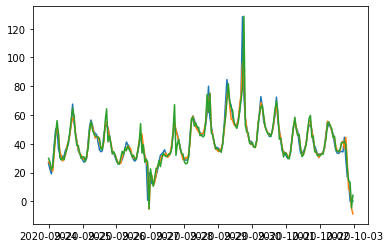

In [200]:
plt.plot(y_test)
plt.plot(y_test.index, pred_lgbm)
plt.plot(y_test.index, pred_ridge)

* On ne peut pas connaitre le x_test ! (les differents lag en avance)

In [202]:
print(mean_squared_error(y_test, pred_lgbm))
print(mean_squared_error(y_test, pred_ridge))

22.99965346832825
51.04181435022356


In [38]:
y_true

,value
time,
2021-01-01 13:00:00,44.73
2021-01-01 14:00:00,46.59
2021-01-01 15:00:00,52.99
2021-01-01 16:00:00,60.26
2021-01-01 17:00:00,60.61
2021-01-01 18:00:00,60.36
2021-01-01 19:00:00,57.40
2021-01-01 20:00:00,53.86
2021-01-01 21:00:00,53.45


In [417]:
datetime.date(2021, 1, 1)

TypeError: descriptor 'date' for 'datetime.datetime' objects doesn't apply to a 'int' object

### Exponential smoothing

In [515]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [516]:
x_train

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_163,t_164,t_165,t_166,t_167,t_168,weekend,month,hour_sin,hour_cos
time,,,,,,,,,,,,,,,,,,,,,
2019-01-08 00:00:00,17.94,1.84,20.82,32.04,40.96,42.05,47.91,53.42,53.26,53.25,...,-17.25,-12.55,-7.41,-9.91,-4.08,10.07,0,1,0.000000,1.000000
2019-01-08 01:00:00,20.91,17.94,1.84,20.82,32.04,40.96,42.05,47.91,53.42,53.26,...,-15.07,-17.25,-12.55,-7.41,-9.91,-4.08,0,1,0.269797,0.962917
2019-01-08 02:00:00,7.78,20.91,17.94,1.84,20.82,32.04,40.96,42.05,47.91,53.42,...,-4.93,-15.07,-17.25,-12.55,-7.41,-9.91,0,1,0.519584,0.854419
2019-01-08 03:00:00,14.33,7.78,20.91,17.94,1.84,20.82,32.04,40.96,42.05,47.91,...,-6.33,-4.93,-15.07,-17.25,-12.55,-7.41,0,1,0.730836,0.682553
2019-01-08 04:00:00,18.56,14.33,7.78,20.91,17.94,1.84,20.82,32.04,40.96,42.05,...,-4.93,-6.33,-4.93,-15.07,-17.25,-12.55,0,1,0.887885,0.460065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-12 01:00:00,45.88,47.24,43.46,46.40,44.93,44.99,49.20,48.59,51.51,45.00,...,28.76,23.35,22.09,18.37,22.04,24.12,1,1,0.269797,0.962917
2019-01-12 02:00:00,44.61,45.88,47.24,43.46,46.40,44.93,44.99,49.20,48.59,51.51,...,36.63,28.76,23.35,22.09,18.37,22.04,1,1,0.519584,0.854419
2019-01-12 03:00:00,42.90,44.61,45.88,47.24,43.46,46.40,44.93,44.99,49.20,48.59,...,40.46,36.63,28.76,23.35,22.09,18.37,1,1,0.730836,0.682553


In [ ]:
n_frames=24
idx = 10000
data_cut = prices[:15000]
x_train = data_cut[:idx].drop("value", axis=1)
y_train = data_cut[:idx]["value"]

x_test = data_cut[idx:].drop("value", axis=1)
y_test = data_cut[idx:]["value"]

In [517]:
prices.shape

(26280, 2)

In [518]:
x_test.shape

(2353, 172)

In [519]:
data.shape

(17353, 173)

In [521]:
x_train.shape

(102, 172)

In [605]:
exp_model = ExponentialSmoothing(endog=y_train, trend="add", seasonal_periods=7, )
exp_model_fit = exp_model.fit(optimized=True)
pred = exp_model_fit.predict(len(x_train), len(x_train)+n_frames)

/home/martin/miniconda3/envs/rhizome/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [606]:
y_test[:n_frames]

time
2020-09-24 00:00:00    26.47
2020-09-24 01:00:00    22.26
2020-09-24 02:00:00    19.08
2020-09-24 03:00:00    26.55
2020-09-24 04:00:00    39.18
2020-09-24 05:00:00    49.97
2020-09-24 06:00:00    51.46
2020-09-24 07:00:00    36.45
2020-09-24 08:00:00    33.01
2020-09-24 09:00:00    29.84
2020-09-24 10:00:00    31.35
2020-09-24 11:00:00    31.42
2020-09-24 12:00:00    35.79
2020-09-24 13:00:00    37.43
2020-09-24 14:00:00    39.76
2020-09-24 15:00:00    46.84
2020-09-24 16:00:00    53.93
2020-09-24 17:00:00    67.57
2020-09-24 18:00:00    54.94
2020-09-24 19:00:00    47.63
2020-09-24 20:00:00    42.01
2020-09-24 21:00:00    35.09
2020-09-24 22:00:00    33.34
2020-09-24 23:00:00    31.92
Name: value, dtype: float64

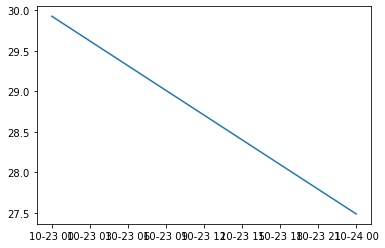

In [607]:
#plt.plot(y_test[:n_frames])
plt.plot(pred)